## Get the data

In [128]:
import pdb

#For the data
from pathlib import Path
import requests
import pickle, gzip

#For the training
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [20]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'mnist'

PATH.mkdir(parents=True, exist_ok=True)

In [21]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

if not (PATH/FILENAME).exists():
    content = requests.get(URL+FILENAME).content
    (PATH/FILENAME).open('wb').write(content)

In [22]:
((x, y), (x_valid, y_valid), _) = pickle.load(gzip.open(PATH/FILENAME, 'rb'), encoding='latin-1')

In [23]:
x,y,x_valid,y_valid = map(torch.tensor, (x,y,x_valid,y_valid))

Current ds/dl

In [24]:
def mnist2image(v): return v.view(1,28,28)

In [25]:
from torch.utils.data import Dataset

class TransformedDataset(Dataset):
    def __init__(self, ds, x_tfms=None, y_tfms=None):
        self.ds,self.x_tfms,self.y_tfms = ds,x_tfms,y_tfms
        
    def __len__(self): return len(self.ds)

    def __getitem__(self,i):
        x,y = self.ds[i]
        if self.x_tfms is not None: x = self.x_tfms(x)
        if self.y_tfms is not None: y = self.y_tfms(y)
        return x,y

In [26]:
default_device = torch.device('cuda')

In [225]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl,self.device = dl,device
        
    def __iter__(self):
        for b in self.dl: yield [o.to(self.device) for o in b]
            
    def __len__(self): return len(self.dl)

In [226]:
class ModelData():
    def __init__(self, train_ds, valid_ds, bs, device):
        train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
        self.train_dl = DeviceDataLoader(train_dl, device)
        valid_dl = DataLoader(valid_ds, batch_size=bs*2)
        self.valid_dl = DeviceDataLoader(valid_dl, device)

In [227]:
bs=64

In [228]:
train_tfm_ds = TransformedDataset(TensorDataset(x, y), mnist2image)
valid_tfm_ds = TransformedDataset(TensorDataset(x_valid, y_valid), mnist2image)
data = ModelData(train_tfm_ds, valid_tfm_ds, bs, default_device)

A first model

In [31]:
class Simple_CNN(nn.Module):
    def __init__(self, actns, kernel_szs, strides):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(actns[i], actns[i+1], kernel_szs[i], stride=strides[i], padding=kernel_szs[i]//2)
            for i in range(len(strides))])

    def forward(self, xb):
        for conv in self.convs: xb = F.relu(conv(xb))
        xb = F.adaptive_avg_pool2d(xb, 1)
        xb = xb.view(-1,xb.size(1))
        return F.log_softmax(xb, dim=-1)

In [36]:
def get_model(): return Simple_CNN([1,16,16,10], [3,3,3], [2,2,2]).to(default_device)

## First implementation of the training loop

In [44]:
def loss_batch(model, xb, yb, loss_fn, opt=None):
    loss = loss_fn(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [45]:
def fit(epochs, model, loss_fn, opt_fn, lr, train_dl, valid_dl=None):
    opt = opt_fn(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl: loss_batch(model, xb, yb, loss_fn, opt)

        model.eval()
        if valid_dl is not None:
            with torch.no_grad():
                losses,nums = zip(*[loss_batch(model, xb, yb, loss_fn)
                                for xb,yb in valid_dl])
            val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

            print(epoch, val_loss)

In [46]:
model = get_model()

In [47]:
loss_fn = F.nll_loss

In [49]:
lr, epochs = 0.5, 2
fit(epochs, model, loss_fn, optim.SGD, lr, data.train_dl, data.valid_dl)

0 0.4102793385028839
1 0.5978511169433594


## LRFinder from scratch

In [60]:
model = get_model()

In [133]:
def lr_find(model, loss_fn, opt_fn, train_dl, num_it=200, start_lr=1e-5, end_lr=10):
    opt = opt_fn(model.parameters(), lr=start_lr)
    #Save the model to begin with.
    MDL_PATH = PATH/'models'
    MDL_PATH.mkdir(exist_ok=True)
    torch.save(model.state_dict(), MDL_PATH/'tmp.pt')
    n = 0
    model.train()
    lrs, losses= [], []
    msa_loss, beta = 0, 0.98
    min_loss = 0
    while n < num_it:
        for xb,yb in train_dl: 
            pct = n / num_it
            lr = start_lr * ((end_lr / start_lr) ** pct)
            for g in opt.param_groups: g['lr'] = lr
            raw_loss = loss_batch(model, xb, yb, loss_fn, opt)[0]
            #smoothes the loss with a mean average
            msa_loss = beta * msa_loss + (1-beta) * raw_loss
            losses.append(msa_loss / (1 - beta ** (n+1)))
            lrs.append(lr)
            if n==0 or msa_loss < min_loss: min_loss = msa_loss
            n += 1
            if n== num_it or msa_loss > 4 * min_loss: break

    #Reload the initial model
    model.load_state_dict(torch.load(MDL_PATH/'tmp.pt'))
    
    return lrs, losses

In [146]:
lrs, losses = lr_find(model, loss_fn, optim.SGD, data.train_dl, end_lr=100)

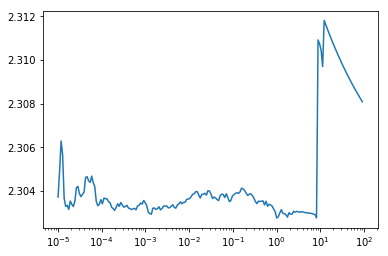

In [139]:
fig, ax = plt.subplots(1)
ax.plot(lrs, losses)
ax.set_xscale('log')

Plot function

In [149]:
def plot_lr(lrs, losses, skip_start=10, skip_end=5):
    fig, ax = plt.subplots(1)
    lrs = lrs[skip_start:-skip_end] if skip_end !=0 else lrs[skip_start:]
    losses = losses[skip_start:-skip_end] if skip_end !=0 else losses[skip_start:]
    ax.plot(lrs, losses)
    ax.set_xscale('log')

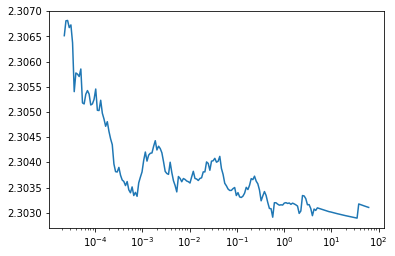

In [151]:
lrs, losses = lr_find(model, loss_fn, optim.SGD, data.train_dl, end_lr=100)
plot_lr(lrs, losses)

## Put the save and load in outside functions.

In [152]:
MDL_PATH = PATH/'models'
MDL_PATH.mkdir(exist_ok=True)

In [465]:
def save_model(model, fname):
    torch.save(model.state_dict(), fname)
    
def load_model(model, fname):
    model.load_state_dict(torch.load(fname))

In [466]:
def lr_find(model, loss_fn, opt_fn, train_dl, num_it=200, start_lr=1e-5, end_lr=10):
    opt = opt_fn(model.parameters(), lr=start_lr)
    #Save the model to begin with.
    save_model(model, MDL_PATH/'tmp.pt')
    n = 0
    model.train()
    lrs, losses= [], []
    msa_loss, beta = 0, 0.98
    min_loss = 0
    while n < num_it:
        for xb,yb in train_dl: 
            pct = n / num_it
            lr = start_lr * ((end_lr / start_lr) ** pct)
            for g in opt.param_groups: g['lr'] = lr
            raw_loss = loss_batch(model, xb, yb, loss_fn, opt)[0]
            #smoothes the loss with a mean average
            msa_loss = beta * msa_loss + (1-beta) * raw_loss
            losses.append(msa_loss / (1 - beta ** (n+1)))
            lrs.append(lr)
            if n==0 or msa_loss < min_loss: min_loss = msa_loss
            n += 1
            if n== num_it or msa_loss > 4 * min_loss: break

    #Reload the initial model
    load_model(model, MDL_PATH/'tmp.pt')
    
    return lrs, losses

## Creates a scheduler to adjust the LR.

In [467]:
from enum import IntEnum
class VarType(IntEnum):
    ''' Data class, each variation type is assigned a number. '''
    NO = 1
    LINEAR = 2
    COSINE = 3
    EXPONENTIAL = 4
    POLYNOMIAL = 5

In [468]:
class Scheduler():
    
    def __init__(self, opt, hp_name, n_iter, varType, start, end=None, extra=None):
        self.opt,self.hp,self.n_iter,self.vType,self.start,self.end,self.extra = opt,hp_name,n_iter,varType,start,end,extra
        if self.end is None and not (self.vType in [1,4]): self.end = 0
        self.reset()
    
    def reset(self):
        self.n = 0
        self.vals = []
        self.set_val(self.start)
    
    def step(self):
        self.n += 1
        if self.n == self.n_iter: return True
        pct = self.n/(self.n_iter-1)
        if self.vType == VarType.NO:
            self.set_val(self.start)
        elif self.vType == VarType.LINEAR:
            self.set_val(self.start + pct * (self.end-self.start))
        elif self.vType == VarType.COSINE:
            cos_out = np.cos(np.pi * pct) + 1
            self.set_val(self.end + (self.start-self.end) / 2 * cos_out)
        elif self.vType == VarType.EXPONENTIAL:
            ratio = self.end / self.start
            self.set_val(self.start * (ratio **  pct))
        elif self.vType == VarType.POLYNOMIAL:
            self.set_val(self.end + (self.start-self.end) * (1 - pct)**self.extra)
        return False
    
    def set_val(self, val):
        self.vals.append(val)
        for g in self.opt.param_groups:
            g[self.hp] = val

In [469]:
def lr_find(model, loss_fn, opt_fn, train_dl, n_iter=200, start_lr=1e-5, end_lr=10):
    opt = opt_fn(model.parameters(), lr=start_lr)
    #Save the model to begin with.
    save_model(model, MDL_PATH/'tmp.pt')
    model.train()
    lrs, losses= [], []
    msa_loss, beta = 0, 0.98
    min_loss = 0
    lr_sched = Scheduler(opt, 'lr', n_iter, VarType.EXPONENTIAL, start_lr, end_lr)
    finished = False
    while not finished:
        for xb,yb in train_dl: 
            #pdb.set_trace()
            raw_loss,_ = loss_batch(model, xb, yb, loss_fn, opt)
            #smoothes the loss with a mean average
            msa_loss = beta * msa_loss + (1-beta) * raw_loss
            losses.append(msa_loss / (1 - beta ** (len(losses)+1)))
            finished = lr_sched.step()
            if len(losses) == 1 or msa_loss < min_loss: min_loss = msa_loss
            if finished or msa_loss > 4 * min_loss: break

    #Reload the initial model
    load_model(model, MDL_PATH/'tmp.pt')
    
    return lr_sched.vals, losses

In [470]:
model = get_model()

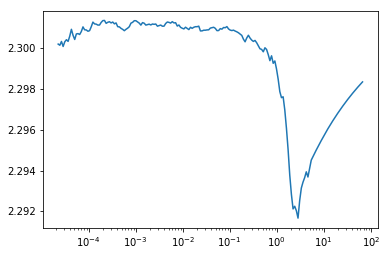

In [471]:
lrs, losses = lr_find(model, loss_fn, optim.SGD, data.train_dl, end_lr=100)
plot_lr(lrs, losses)

## Refactors inside to use the fit function

In [389]:
class Callback():
    
    def on_train_begin(self): pass
    def on_batch_end(self, raw_loss): pass

In [390]:
class LossRecorder(Callback):
    
    beta = 0.98
    
    def on_train_begin(self):
        self.msa_loss,self.losses = 0,[]
        
    def on_batch_end(self, raw_loss):
        self.msa_loss = self.beta * self.msa_loss + (1-self.beta) * raw_loss
        self.losses.append(self.msa_loss / (1 - self.beta ** (len(self.losses)+1)))
        stop = False
        return stop

In [391]:
class LRFinderCallback(LossRecorder):
    
    def __init__(self, opt, n_iter, start_lr, end_lr):
        self.sched = Scheduler(opt, 'lr', n_iter, VarType.EXPONENTIAL, start_lr, end_lr)
        super().__init__()
        
    def on_train_begin(self):
        self.min_loss = 0
        super().on_train_begin()
    
    def on_batch_end(self, raw_loss):
        super().on_batch_end(raw_loss)
        loss = self.losses[-1]
        if len(self.losses) == 1 or loss < self.min_loss: self.min_loss = loss
        stop = self.sched.step()
        if loss > 4 * self.min_loss: return True
        return stop

In [392]:
def loss_batch(model, xb, yb, loss_fn, opt=None):
    loss = loss_fn(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

basic_fit differs from fit in the sense it gets an optimizer instead of an opt_fn.

In [393]:
def basic_fit(epochs, model, loss_fn, opt, train_dl, valid_dl=None, callbacks=[]):
    
    for cb in callbacks: cb.on_train_begin()
    
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl: 
            raw_loss,_ = loss_batch(model, xb, yb, loss_fn, opt)
            
            stop = False
            for cb in callbacks: stop = stop or cb.on_batch_end(raw_loss)
            if stop: break  
                
        model.eval()
        if valid_dl is not None:
            with torch.no_grad():
                losses,nums = zip(*[loss_batch(model, xb, yb, loss_fn)
                                for xb,yb in valid_dl])
            val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

            print(epoch, val_loss)

In [394]:
def lr_find(model, loss_fn, opt_fn, train_dl, n_iter=200, start_lr=1e-5, end_lr=10):
    opt = opt_fn(model.parameters(), lr=start_lr)
    #Save the model to begin with.
    save_model(model, MDL_PATH/'tmp.pt')
    
    cb = LRFinderCallback(opt, n_iter, start_lr, end_lr)
    epochs = int(np.ceil(n_iter/len(train_dl)))
    basic_fit(epochs, model, loss_fn, opt, train_dl, callbacks=[cb])
    
    #Reload the initial model
    load_model(model, MDL_PATH/'tmp.pt')
    
    return cb.sched.vals, cb.losses

In [395]:
model = get_model()

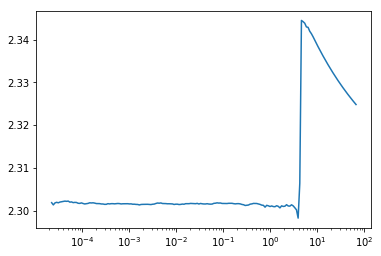

In [396]:
lrs, losses = lr_find(model, loss_fn, optim.SGD, data.train_dl, end_lr=100)
plot_lr(lrs, losses)

## Training phases and SGDR

A few helper functions. The second one is there to map the names of the hyper-parameters in pytorch optimizers to 'momentum' and 'beta' (whether it's SGD, Adam, RMSProp)

In [422]:
def is_tuple(x): return isinstance(x, tuple)

In [456]:
def set_val_in_group(val, group, key):
    if key == 'momentum' and 'betas' in group:  group['betas'] = (val, group['betas'][1])
    elif key == 'beta' and 'betas' in group:    group['betas'] = (group['betas'][0], val)
    elif key == 'beta' and 'alpha' in group:    group['alpha'] = val
    else:                                       group[key] = val

In [457]:
def set_val_in_groups(val, groups, key):
    for g in groups: set_val_in_group(val, g, key)

To simplify the use of training phase, the args lr and mom can either be:
- a single value, then it's assumed to have it constant during the phase
- a tuple (lr1, lr2), then the default is to go linearly from one to the other
- a tuple (lr1, lr2, VarType), then we go from one to the other using the VarType given.

In [458]:
class TrainingPhase():
    
    def __init__(self, epochs, opt_fn, lr, mom=0.9, beta=None, wds=None):
        self.epochs,self.opt_fn,self.beta,self.wds = epochs,opt_fn,beta,wds
        self.start_lr, self.end_lr, self.lr_vType, self.extra_lr = self.decode(lr)
        self.start_mom, self.end_mom, self.mom_vType, self.extra_mom = self.decode(mom)
        
    def decode(self, vals):
        if is_tuple(vals):
            if len(vals) == 2: return vals + (VarType.LINEAR, None)
            elif len(vals) == 3: return vals + (None,)
            else: return vals
        else: return vals, None, VarType.NO, None
    
    def get_scheds(self, opt, n_batch):
        if self.beta is not None: set_val_in_groups(self.beta, opt.param_groups, 'beta')
        if self.wds is not None: set_val_in_groups(self.wds, opt.param_groups, 'weight_decay')
        return [Scheduler(opt, 'lr', n_batch * self.epochs, self.lr_vType, self.start_lr, self.end_lr, self.extra_lr),
               Scheduler(opt, 'momentum', n_batch * self.epochs, self.mom_vType, self.start_mom, self.end_mom, self.extra_mom)]

Scheduler is adjusted to use the set_val_in_group function.

In [459]:
class Scheduler():
    
    def __init__(self, opt, hp_name, n_iter, varType, start, end=None, extra=None):
        self.opt,self.hp,self.n_iter,self.vType,self.start,self.end,self.extra = opt,hp_name,n_iter,varType,start,end,extra
        if self.end is None and not (self.vType in [1,4]): self.end = 0
        self.reset()
    
    def reset(self):
        self.n = 0
        self.vals = []
        self.set_val(self.start)
    
    def step(self):
        self.n += 1
        if self.n == self.n_iter: return True
        pct = self.n/(self.n_iter-1)
        if self.vType == VarType.NO:
            self.set_val(self.start)
        elif self.vType == VarType.LINEAR:
            self.set_val(self.start + pct * (self.end-self.start))
        elif self.vType == VarType.COSINE:
            cos_out = np.cos(np.pi * pct) + 1
            self.set_val(self.end + (self.start-self.end) / 2 * cos_out)
        elif self.vType == VarType.EXPONENTIAL:
            ratio = self.end / self.start
            self.set_val(self.start * (ratio **  pct))
        elif self.vType == VarType.POLYNOMIAL:
            self.set_val(self.end + (self.start-self.end) * (1 - pct)**self.extra)
        return False
    
    def set_val(self, val):
        self.vals.append(val)
        set_val_in_groups(val, self.opt.param_groups, self.hp)

The class that handles the phases and make sure we go from one to the next is another Callback.

In [460]:
class PhaseScheduler(LossRecorder):
    
    def __init__(self, model, phases, n_batches):
        self.model, self.phases, self.n_batches = model, phases, n_batches
        super().__init__()
        self.phase = 0
        self.opt = None
        self.init_phase()
    
    def init_phase(self):
        cur_phase = self.phases[self.phase]
        #Updates the optimizer
        #Replacing self.model.parameters() by a function that returns the trainable parameters will handle freezing.
        new_opt = cur_phase.opt_fn(self.model.parameters(), lr=cur_phase.start_lr)
        if self.opt is None or type(self.opt) != type(new_opt): self.opt = new_opt
        #Creates the various schedulers
        self.scheds = cur_phase.get_scheds(self.opt, self.n_batches)
        
    def on_batch_end(self, raw_loss):
        super().on_batch_end(raw_loss)
        finished = False
        for sched in self.scheds: finished = finished or sched.step()
        if finished:
            self.phase += 1
            if self.phase == len(self.phases): return True
            self.init_phase()

fitting with phases is then super easy

In [461]:
def fit_phases(phases, model, loss_fn, train_dl, valid_dl=None, callbacks=[]):
    epochs = int(np.ceil(sum([p.epochs for p in phases])))
    cb = PhaseScheduler(model, phases, len(train_dl))
    basic_fit(epochs, model, loss_fn, cb.opt, train_dl, valid_dl, callbacks=[cb])

An example of what a helper function could be.

In [462]:
def sgdr_phases(lr, opt_fn, n_cycle, cyc_len, cyc_mul, mom=0.9, wds=None):
    phases = [TrainingPhase(0.05, opt_fn, lr/100, mom, wds)]
    for i in range(n_cycle):
        epochs = cyc_len - 0.05 if i==0 else cyc_len * (cyc_mul ** i)
        phases.append(TrainingPhase(epochs, opt_fn, (lr,0,VarType.COSINE), mom, wds))
    return phases

In [463]:
model = get_model()

In [464]:
fit_phases(sgdr_phases(1, optim.SGD, 2, 1, 2, wds=1e-4), model, loss_fn, data.train_dl, data.valid_dl)

0 1.347146787261963
1 0.69737041015625
2 0.5230010066509246


## Changes scheduler to handle discriminative learning rates

In [414]:
import collections
def is_iter(x): return isinstance(x,collections.Iterable)

As long as the values given are numpy arrays, the scheduler can handle differential learning rates.

In [418]:
class Scheduler():
    
    def __init__(self, opt, hp_name, n_iter, varType, start, end=None, extra=None):
        self.opt,self.hp,self.n_iter,self.vType,self.start,self.end,self.extra = opt,hp_name,n_iter,varType,start,end,extra
        if self.end is None and not (self.vType in [1,4]): self.end = 0
        self.reset()
    
    def reset(self):
        self.n = 0
        self.vals = []
        self.set_val(self.start)
    
    def step(self):
        self.n += 1
        if self.n == self.n_iter: return True
        pct = self.n/(self.n_iter-1)
        if self.vType == VarType.LINEAR:
            self.set_val(self.start + pct * (self.end-self.start))
        elif self.vType == VarType.COSINE:
            cos_out = np.cos(np.pi * pct) + 1
            self.set_val(self.end + (self.start-self.end) / 2 * cos_out)
        elif self.vType == VarType.EXPONENTIAL:
            ratio = self.end / self.start
            self.set_val(self.start * (ratio **  pct))
        elif self.vType == VarType.POLYNOMIAL:
            self.set_val(self.end + (self.start-self.end) * (1 - pct)**self.extra)
        return False
    
    def set_val(self, val):
        if is_iter(val): self.vals.append(val[-1])
        else: 
            self.vals.append(val)
            val = [val]
        if len(val) == 1: val = val * len(param_group)
        assert(len(val) == len(param_group))
        for v, g in zip(val,param_group):
            set_val_in_group(v, g, self.hp)